In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import numpy as np
import copy
import keras
from ar_capsulelayers import Mask, margin_loss, PrimaryCap, Length, margin_loss, ConvCaps, FullyConvCaps
import os
from ar_capsulenet import *

Using TensorFlow backend.


In [2]:
from keras.datasets import mnist

## MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


In [3]:
def model_():
    input_shape = x_train[0].shape
    kernel_regularizer=regularizers.l2(0)

    input_layer = Input(shape=input_shape)

    conv1 = Conv2d_bn(input_tensor = input_layer, filters=64, kernel_size=3, strides=1, padding='same', activation='relu',
                     kernel_regularizer=kernel_regularizer)
    conv1 = Conv2d_bn(input_tensor = conv1, filters=64, kernel_size=3, strides=1, padding='same', activation='relu',
                     kernel_regularizer=kernel_regularizer)

    ## Primary Capsules
    primarycaps = PrimaryCap(n_channels=8, dim_capsule=16, kernel_regularizer=kernel_regularizer)(conv1)
    primarycaps = Activation('tanh')(primarycaps)
    print('primary caps shape : ', primarycaps.shape)

    ## Fully Convolutional Capsules
    output_dim_capsule = 32
    outputs = FullyConvCaps(n_channels=10, dim_capsule=output_dim_capsule, kernel_regularizer=kernel_regularizer)(primarycaps)
    outputs = Activation('tanh')(outputs)
    print('Final Routing caps shape : ', outputs.shape)

    ## Length Capsules
    real_outputs = Length()(outputs)
    print('Length shape : ', real_outputs.shape)


    from keras import models

    n_class=10

    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([outputs, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(outputs)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=output_dim_capsule*n_class, kernel_regularizer=kernel_regularizer))
    decoder.add(layers.Dense(512, activation='relu', kernel_regularizer=kernel_regularizer))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid', kernel_regularizer=kernel_regularizer))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    train_model = models.Model([input_layer, y], [real_outputs, decoder(masked_by_y)])
    # manipulate model
    noise = layers.Input(shape=(n_class, output_dim_capsule))
    noised_outputs = layers.Add()([outputs, noise])
    masked_noised_y = Mask()([noised_outputs, y])
    manipulate_model = models.Model([input_layer, y, noise], [outputs, decoder(masked_noised_y)])

    return train_model, manipulate_model


In [5]:
model, manipulate_model = model_()
model.load_weights('./result/weights-06.h5')
manipulate_model.load_weights('./result/weights-06.h5')

primary caps shape :  (?, 14, 14, 16, 8)
Final Routing caps shape :  (?, 10, 32)
Length shape :  (?, 10)


In [6]:
from PIL import Image
import math

def combine_images(generated_images, height=None, width=None):
    num = generated_images.shape[0]
    if width is None and height is None:
        width = int(math.sqrt(num))
        height = int(math.ceil(float(num)/width))
    elif width is not None and height is None:  # height not given
        height = int(math.ceil(float(num)/width))
    elif height is not None and width is None:  # width not given
        width = int(math.ceil(float(num)/height))

    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

def manipulate_latent(model, data, digit, output_dim_capsule, save_dir='./result/'):
    """ digit : digit to manipulate """
    print('-'*30 + 'Begin: manipulate' + '-'*30)
    x_test, y_test = data
    index = np.argmax(y_test, 1) == digit
    number = np.random.randint(low=0, high=sum(index) - 1)
    x, y = x_test[index][number], y_test[index][number]
    x, y = np.expand_dims(x, 0), np.expand_dims(y, 0)
    noise = np.zeros([1, 10, output_dim_capsule])
    x_recons = []
    logits = []
    for dim in range(output_dim_capsule):
        for r in np.array([-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25]) * np.sqrt(output_dim_capsule):
            tmp = np.copy(noise)
            tmp[:,:,dim] = r
            #print(r)
            logit, x_recon = model.predict([x, y, tmp])
            x_recons.append(x_recon)
            
            #plt.imshow(x_recon[0,:,:,0], cmap='gray')
            #plt.show()
            
            logits.append(logit)

    x_recons = np.concatenate(x_recons)
#    print(x_recons.shape)

    img = combine_images(x_recons, height=output_dim_capsule)
    image = img*255
    Image.fromarray(image.astype(np.uint8)).save(save_dir + '/manipulate-%d.png' % digit)
    print('manipulated result saved to %s/manipulate-%d.png' % (save_dir, digit))
    print('-' * 30 + 'End: manipulate' + '-' * 30)
    return logits

In [7]:
""" Save Manipulated Images """
for i in range(10):
    logits = manipulate_latent(manipulate_model, (x_test, y_test), i, output_dim_capsule=32)

------------------------------Begin: manipulate------------------------------
manipulated result saved to ./result//manipulate-0.png
------------------------------End: manipulate------------------------------
------------------------------Begin: manipulate------------------------------
manipulated result saved to ./result//manipulate-1.png
------------------------------End: manipulate------------------------------
------------------------------Begin: manipulate------------------------------
manipulated result saved to ./result//manipulate-2.png
------------------------------End: manipulate------------------------------
------------------------------Begin: manipulate------------------------------
manipulated result saved to ./result//manipulate-3.png
------------------------------End: manipulate------------------------------
------------------------------Begin: manipulate------------------------------
manipulated result saved to ./result//manipulate-4.png
------------------------------E

In [5]:
import matplotlib.pylab as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7
import cv2
import numpy as np

a = model
inputs = a.inputs[0]
outputs = a.layers[-5]
from keras import models
experiment_model = models.Model(inputs=inputs, outputs = outputs.output)

experiment_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 64)        0         
__________

In [11]:
data = {}
x_cos = []
y_cos = []
r_cos = []

for num in range(10):
    for trans in ['x', 'y', 'r']:
        align_vector_pos_list = []
        align_vector_neg_list = []
        
        for sign in [-1, 1]: 
            ind = (y_test[:,num] == 1)
            sample = x_test[ind]
            print(sample.shape[0])
            img = x_test[0,:,:,0]
            rows,cols = img.shape
            variation = np.zeros((sample.shape[0]*5,28,28,1))
            for i in range(sample.shape[0]):
                for j in range(5):
                    img = sample[i,...,0]
                    if trans == 'x':
                        M = np.float32([[1,0,sign*(j+1)],[0,1,0]]) #x    
                    elif trans == 'y':
                        M = np.float32([[1,0,0],[0,1,sign*(j+1)]]) #y
                    elif trans == 'r':
                        M = cv2.getRotationMatrix2D((cols/2,rows/2), sign*5*(j+1),1) # 회전

                    dst = cv2.warpAffine(img,M,(cols,rows))
                    variation[i*5+j,...,0] = dst

            capsules = experiment_model.predict([variation])
            sample_repeat = sample.repeat(5, axis=0)
            ori_caps = experiment_model.predict([sample_repeat])
            _transform = (capsules[:,num,:]-ori_caps[:,num,:])


            m = []
            for i in range(sample.shape[0]):
            # for i in range(10):
                stat=[]
                U, S, VT = np.linalg.svd(_transform[5*i:5*(i+1)])
                align_vector = VT[0,:]
                if sign == 1:
                    align_vector_pos_list.append(align_vector)
                elif sign == -1:
                    align_vector_neg_list.append(align_vector)

                for j in range(5):
                    a = _transform[5*i:5*i+5][j,:]
                    stat.append(np.dot(align_vector,a)/np.linalg.norm(a))
                m.append(np.mean(np.abs(stat)))

            print(num, trans, sign, np.mean(m))
            data[num, trans, sign, 'mean'] = np.mean(m)
            data[num, trans, sign, 'std']  = np.std(m)
        
        if trans == 'x':
            x_cos.extend([np.dot(p, n) for p, n in zip(align_vector_pos_list, align_vector_neg_list)])
        if trans == 'y':
            y_cos.extend([np.dot(p, n) for p, n in zip(align_vector_pos_list, align_vector_neg_list)])
        if trans == 'r':
            r_cos.extend([np.dot(p, n) for p, n in zip(align_vector_pos_list, align_vector_neg_list)])

        data[num, trans, 0, 'cos'] = [np.dot(p, n) for p, n in zip(align_vector_pos_list, align_vector_neg_list)]

980
0 x -1 0.971604
980
0 x 1 0.909798
980
0 y -1 0.90359
980
0 y 1 0.920882
980
0 r -1 0.950726
980
0 r 1 0.940462
1135
1 x -1 0.961737
1135
1 x 1 0.956858
1135
1 y -1 0.978165
1135
1 y 1 0.953303
1135
1 r -1 0.975991
1135
1 r 1 0.976087
1032
2 x -1 0.930783
1032
2 x 1 0.978145
1032
2 y -1 0.917883
1032
2 y 1 0.929983
1032
2 r -1 0.913678
1032
2 r 1 0.919929
1010
3 x -1 0.948567
1010
3 x 1 0.960926
1010
3 y -1 0.889972
1010
3 y 1 0.889944
1010
3 r -1 0.956807
1010
3 r 1 0.942607
982
4 x -1 0.943585
982
4 x 1 0.943394
982
4 y -1 0.939764
982
4 y 1 0.919357
982
4 r -1 0.931117
982
4 r 1 0.931171
892
5 x -1 0.975442
892
5 x 1 0.961543
892
5 y -1 0.897535
892
5 y 1 0.892889
892
5 r -1 0.941471
892
5 r 1 0.932667
958
6 x -1 0.93421
958
6 x 1 0.951394
958
6 y -1 0.894396
958
6 y 1 0.928894
958
6 r -1 0.942588
958
6 r 1 0.94905
1028
7 x -1 0.931541
1028
7 x 1 0.949886
1028
7 y -1 0.942303
1028
7 y 1 0.969488
1028
7 r -1 0.893079
1028
7 r 1 0.926013
974
8 x -1 0.933179
974
8 x 1 0.969322
974


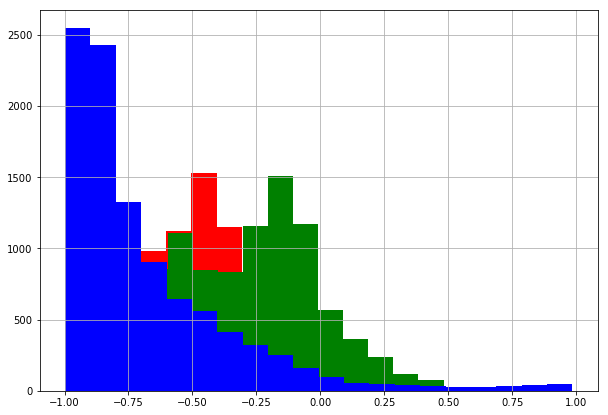

In [28]:
plt.hist(x_cos, bins =20, color='r')
plt.grid(True)

plt.hist(y_cos, bins =20, color='g')
plt.grid(True)

plt.hist(r_cos, bins =20, color='b')
plt.grid(True)

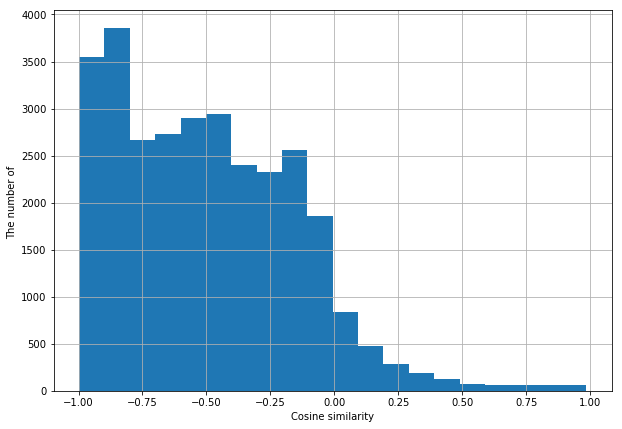

In [13]:
t_cos = []
t_cos.extend(x_cos)
t_cos.extend(y_cos)
t_cos.extend(r_cos)

f = plt.figure()
plt.hist(t_cos, bins =20)
plt.grid(True)
plt.xlabel('Cosine similarity')
plt.ylabel('The number of ')
plt.show()

f.savefig("hist_ours.pdf", bbox_inches='tight')


In [14]:
import pandas as pd
df_pos_mean = pd.DataFrame.from_dict({'num':np.array(range(10)), 
                                     'x translation': [data[i, 'x', 1, 'mean'] for i in range(10)],
                                     'y translation': [data[i, 'y', 1, 'mean'] for i in range(10)],
                                     'rotation translation': [data[i, 'r', 1, 'mean'] for i in range(10)],
                                    })
df_pos_std = pd.DataFrame.from_dict({'num':np.array(range(10)), 
                                     'x translation': [data[i, 'x', 1, 'std'] for i in range(10)],
                                     'y translation': [data[i, 'y', 1, 'std'] for i in range(10)],
                                     'rotation translation': [data[i, 'r', 1, 'std'] for i in range(10)],
                            })




df_neg_mean = pd.DataFrame.from_dict({'num':np.array(range(10)), 
                                     'x translation': [data[i, 'x', -1, 'mean'] for i in range(10)],
                                     'y translation': [data[i, 'y', -1, 'mean'] for i in range(10)],
                                     'rotation translation': [data[i, 'r', -1, 'mean'] for i in range(10)],
                                    })
df_neg_std = pd.DataFrame.from_dict({'num':np.array(range(10)), 
                                     'x translation': [data[i, 'x', -1, 'std'] for i in range(10)],
                                     'y translation': [data[i, 'y', -1, 'std'] for i in range(10)],
                                     'rotation translation': [data[i, 'r', -1, 'std'] for i in range(10)],
                            })

In [16]:
print(df_pos_mean)

,num,rotation translation,x translation,y translation
0,0,0.940462,0.909798,0.920882
1,1,0.976087,0.956858,0.953303
2,2,0.919929,0.978145,0.929983
3,3,0.942607,0.960926,0.889944
4,4,0.931171,0.943394,0.919357
5,5,0.932667,0.961543,0.892889
6,6,0.949050,0.951394,0.928894
7,7,0.926013,0.949886,0.969488
8,8,0.960474,0.969322,0.891201
9,9,0.955798,0.962554,0.918340


In [15]:
df_neg_mean

,num,rotation translation,x translation,y translation
0,0,0.950726,0.971604,0.903590
1,1,0.975991,0.961737,0.978165
2,2,0.913678,0.930783,0.917883
3,3,0.956807,0.948567,0.889972
4,4,0.931117,0.943585,0.939764
5,5,0.941471,0.975442,0.897535
6,6,0.942588,0.934210,0.894396
7,7,0.893079,0.931541,0.942303
8,8,0.949786,0.933179,0.930319
9,9,0.948866,0.942089,0.948438
